#Mixture 2 line elements

Using Bayesian Gaussian process latent variable model with back constraints to discover different segments in the composite model Mixture 2.

Made by Ivan De Boi (ivan.deboi at uantwerpen.be, http://www.InViLab.be).

In [58]:
shape_name_string = 'Mixture 2'

# Imports

In [59]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

import warnings
warnings.filterwarnings('ignore')

from matplotlib import cm

!pip install GPy
import GPy
from GPy.util import pca
from GPy import kern
GPy.plotting.change_plotting_library('matplotlib')
from GPy import mappings

from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from numpy import genfromtxt

from google.colab import drive
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
#use this to adjust the resolution of the pictures etc.
#print(plt.rcParams)  # it will tell you all default setting in Matplotlib
print(plt.rcParams.get('figure.figsize'))
plt.rcParams['figure.figsize'] = [8,6]
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('figure.dpi'))
plt.rcParams['figure.dpi'] = 72.0*3
print(plt.rcParams.get('figure.dpi'))

[6.0, 4.0]
[8.0, 6.0]
72.0
216.0


# Data

In [61]:
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/PhD 3D Sensing/05 GPLVM on set of lines/Line Elements Surface/Line Elements/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
data = genfromtxt(root_path + shape_name_string + ' line elements.csv', delimiter=',')
shape_name_string
Y = data[:,:]
print(Y[0:3,:])
print(Y.shape)

[[ 0.04346649  0.21554494  0.97552603  0.03902164  0.00705647 -0.00329783
   1.00314271]
 [ 0.00731387  0.18333961  0.98302251  0.03251988 -0.00717776  0.00109674
   1.00090718]
 [ 0.08430092  0.19031279  0.97809732  0.02128758  0.00582355 -0.00296786
   1.00155747]]
(6555, 7)


# PCA

In [63]:
# Normalize
scaler = StandardScaler()
scaler.fit(Y)

Yn = scaler.transform(Y)
print(Yn[0:3, :])

# Sanity checks
print("mean y:",Y.mean())
print("std y:", Y.std())
print("mean yn:", Yn.mean())
print("std yn:", Yn.std())

[[ 0.06647038  0.33140721  2.36146996  0.13873263  0.02998801 -0.12689231
   0.89882354]
 [ 0.01098178  0.28197811  2.38494323  0.11150721 -0.02976424  0.04264684
   0.79515237]
 [ 0.12914483  0.29268062  2.36952127  0.06447319  0.02481249 -0.11416236
   0.82530894]]
mean y: 0.17295628746449487
std y: 0.5173200439922517
mean yn: -6.937411912836982e-17
std yn: 1.0


In [64]:
points = np.zeros((Y.shape[0], 3))
for i in range(Y.shape[0]):
  p = np.cross(Y[i,0:3], Y[i,3:6]) + Y[i,6]*Y[i,0:3]
  points[i,:] = p

print(points)
print(points.shape)


labels = points[:,2]*0
labels[np.where(points[:,2] < 0.2)] = 1

print(labels)
print(labels.shape)

fig = go.Figure(data=[go.Scatter3d(x=points[:, 0], y=points[:, 1], z=points[:, 2],
                                   mode='markers',
                                   marker=dict(size=2, color = labels, colorscale='Spectral',opacity=0.8)
                                   )])
fig.show(figsize=(20, 20))
plt.figure(figsize=(30, 30))

[[ 0.03600849  0.25443231  0.97048764]
 [ 0.01457749  0.21546568  0.97789961]
 [ 0.07817139  0.21168071  0.97606031]
 ...
 [-0.14160681  0.98677249  0.19969802]
 [-0.09765247  0.99170395  0.20258604]
 [-0.04652089  0.99620507  0.19960607]]
(6555, 3)
[0. 0. 0. ... 1. 0. 1.]
(6555,)


<Figure size 6480x6480 with 0 Axes>

<Figure size 6480x6480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

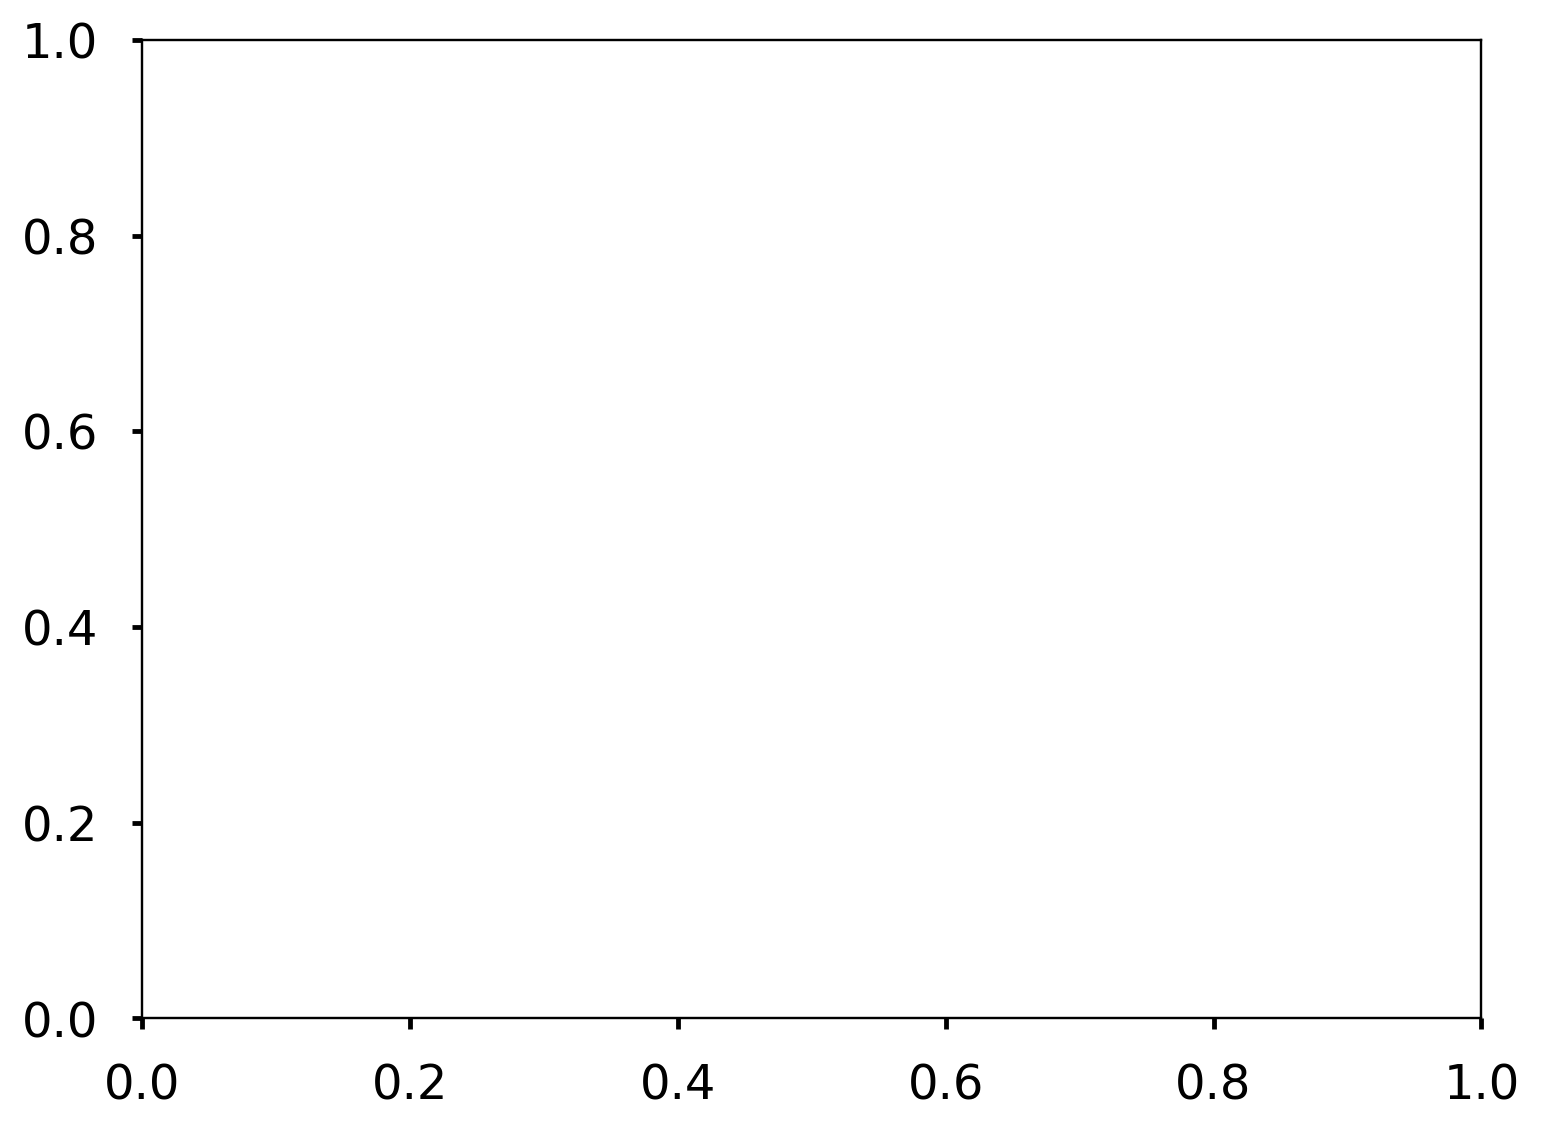

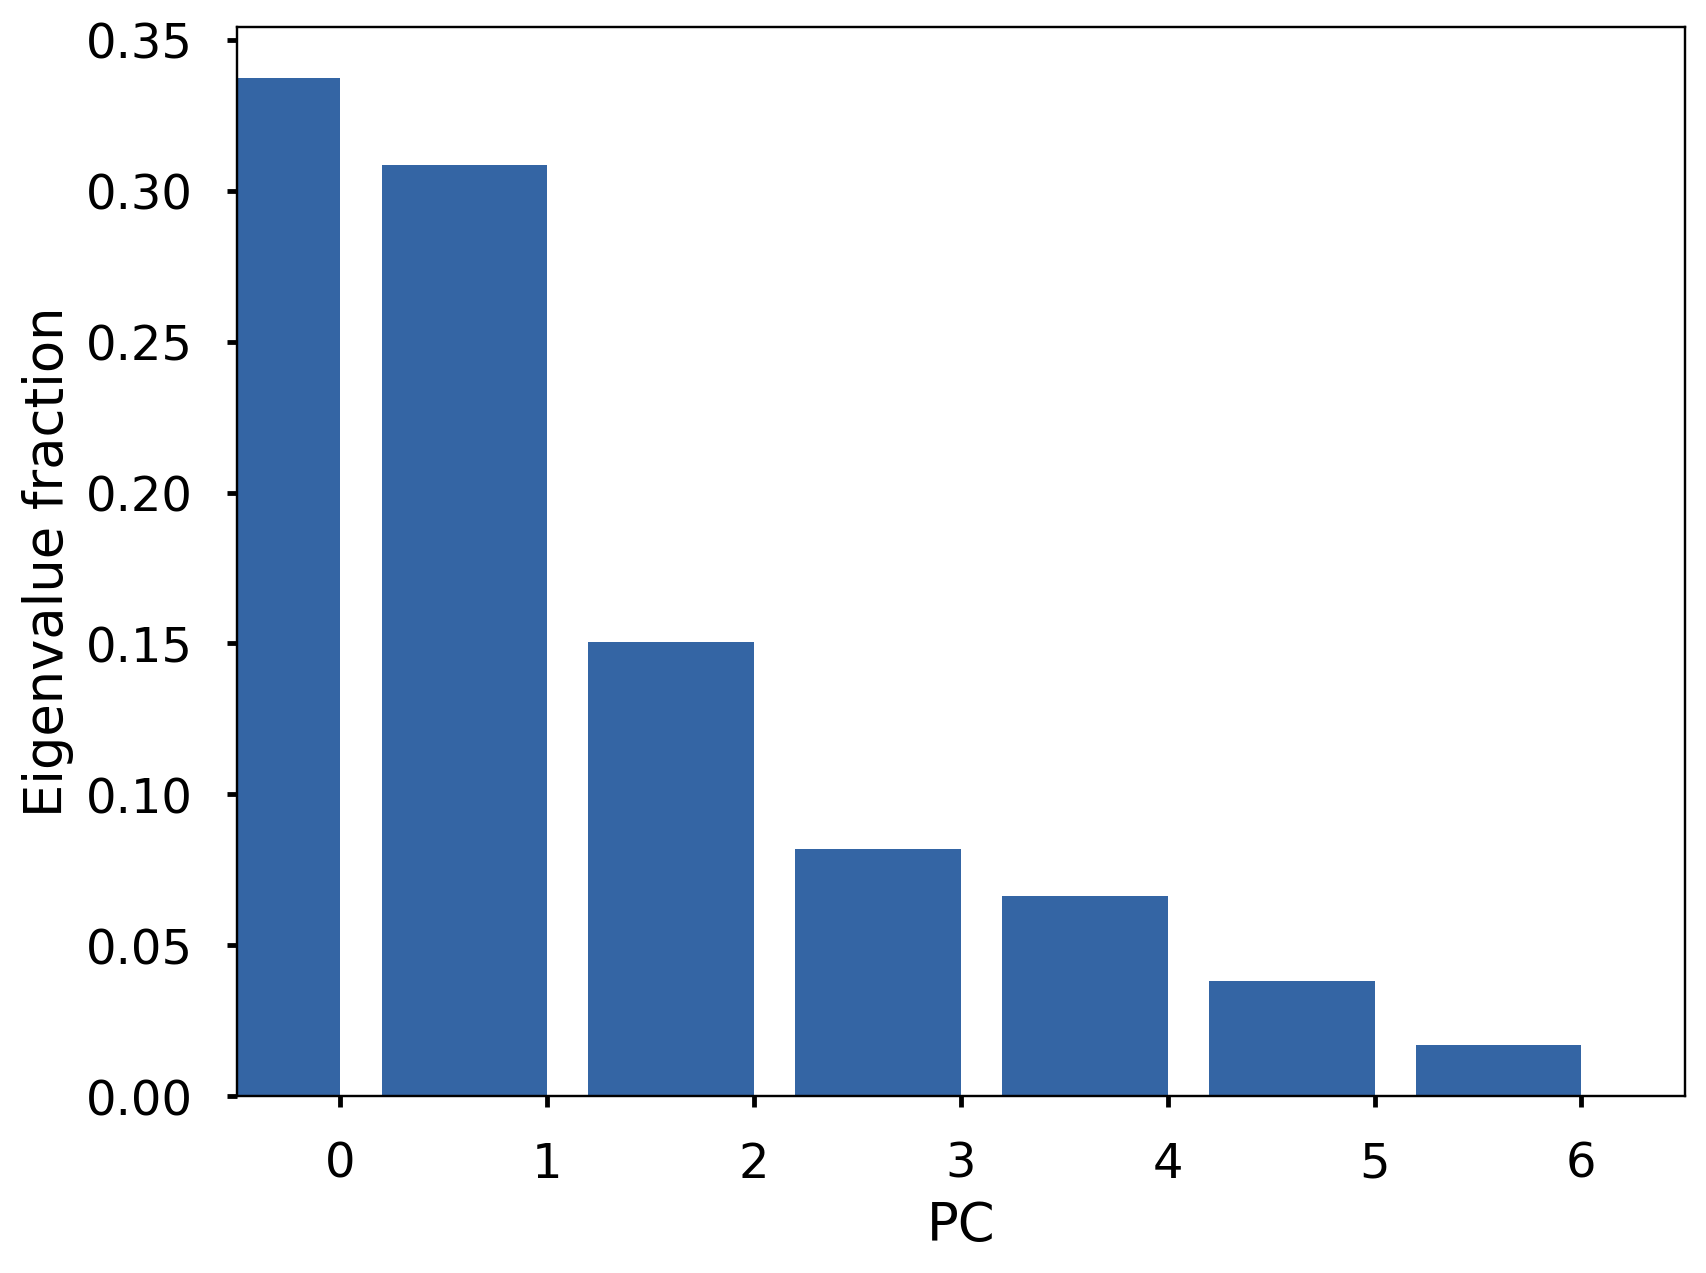

In [65]:
p = pca.PCA(Yn)
# plot first xxx eigenvalue fractions

fig, ax = plt.subplots()
p.plot_fracs(Yn.shape[1]) 

filename = shape_name_string + ' PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

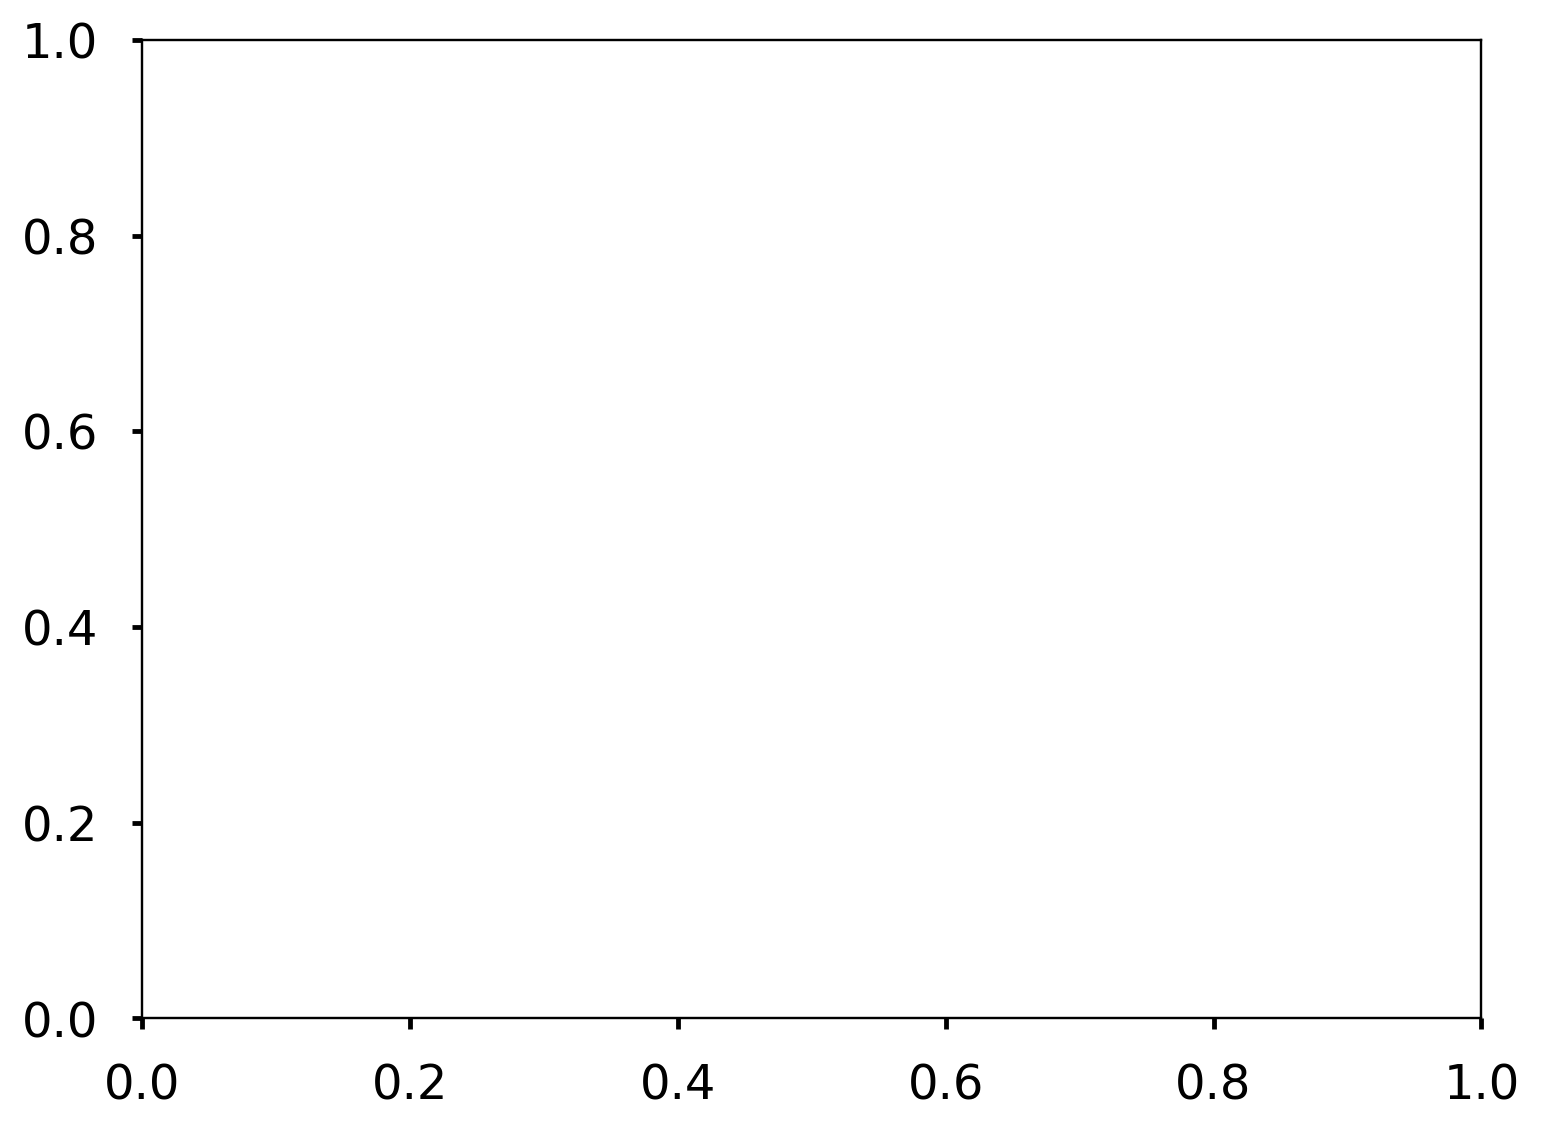

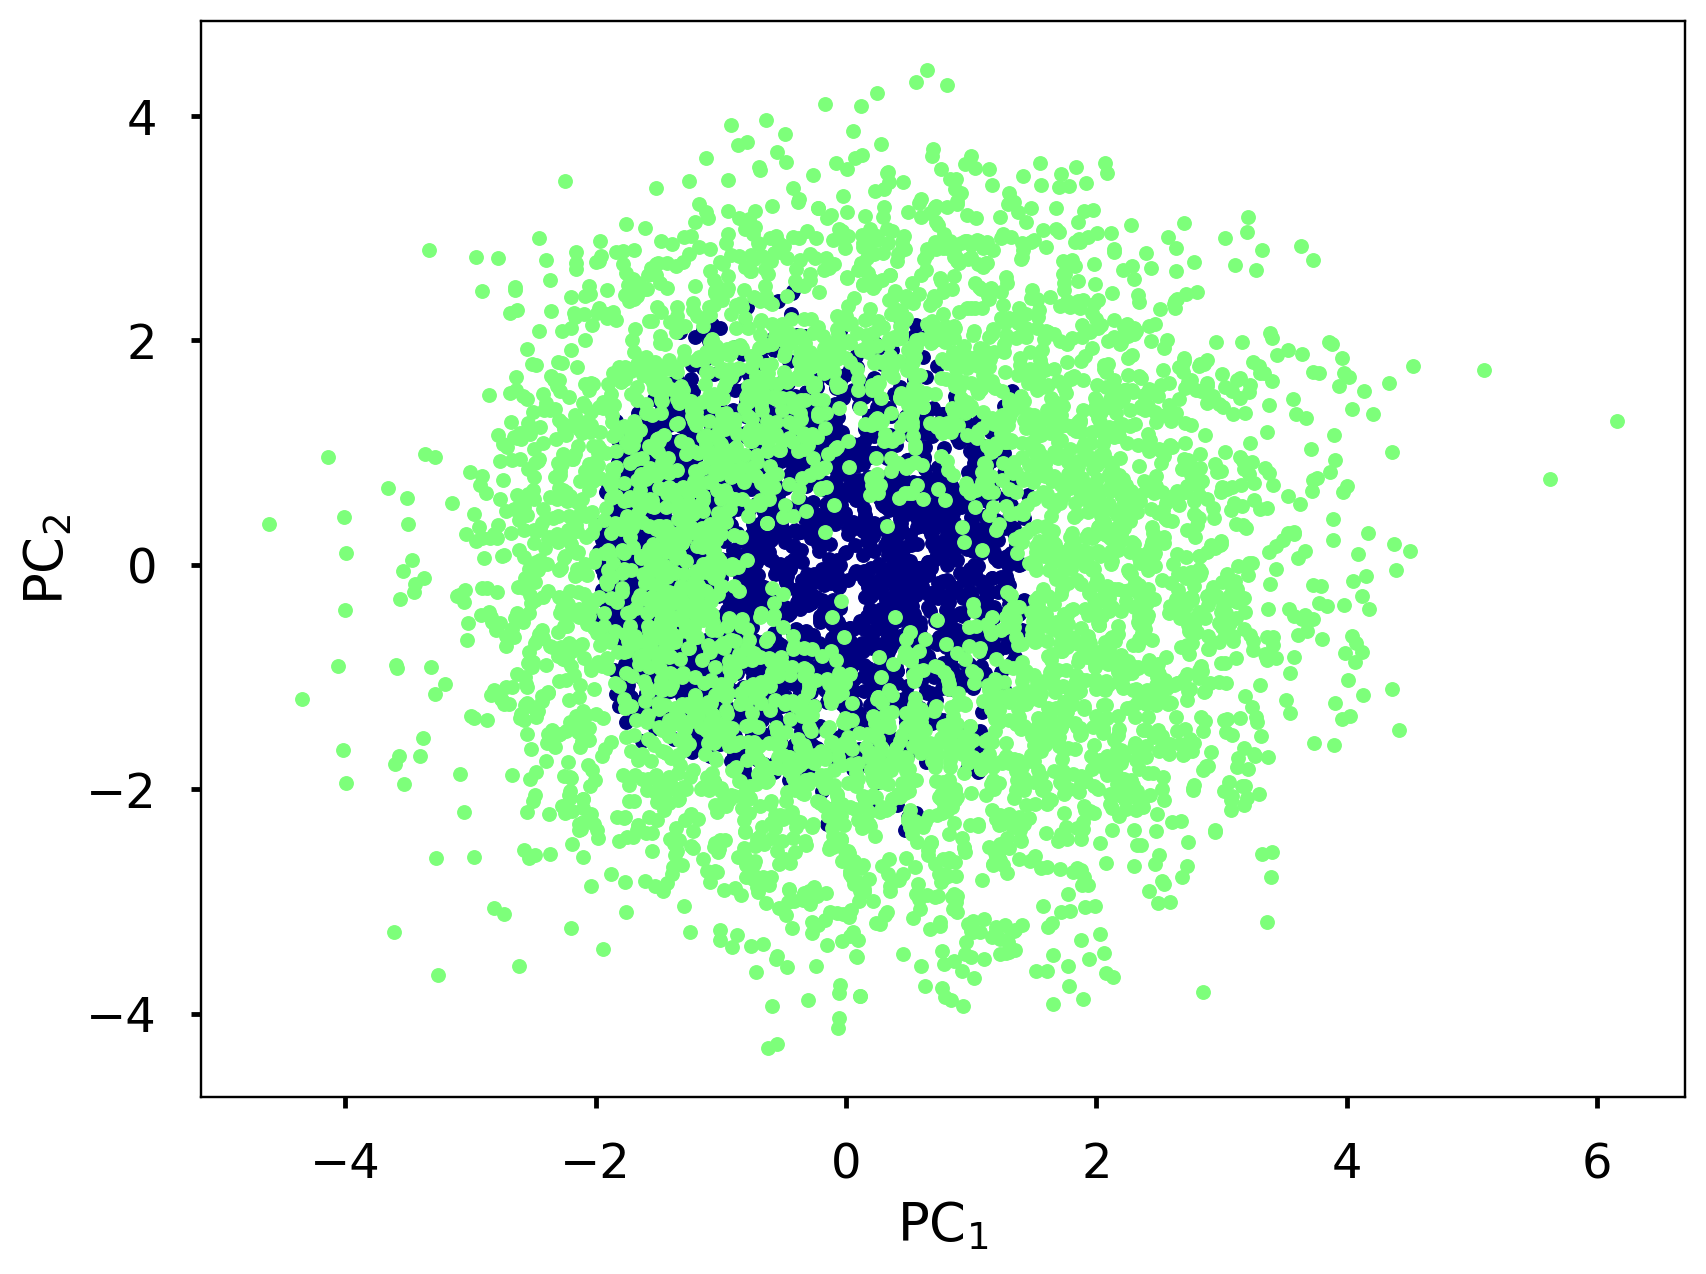

In [66]:
# plot the latent space by PCA

fig, ax = plt.subplots()
p.plot_2d(Yn, labels = labels)

filename = shape_name_string + ' 2D PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

# BCGPLVM

In [67]:
print(Y[0:3,:])

[[ 0.04346649  0.21554494  0.97552603  0.03902164  0.00705647 -0.00329783
   1.00314271]
 [ 0.00731387  0.18333961  0.98302251  0.03251988 -0.00717776  0.00109674
   1.00090718]
 [ 0.08430092  0.19031279  0.97809732  0.02128758  0.00582355 -0.00296786
   1.00155747]]


In [68]:
max_nr_of_data_points = 1000 #use this line to subsample
#max_nr_of_data_points = Y.shape[0]
Y = Y[np.random.choice(Y.shape[0], max_nr_of_data_points, replace=False), :] #permutation on the datapoints
print(Y[0:3,:])


[[-0.23772334  0.85447472  0.46190971  0.00204682 -0.01437344  0.02764246
   1.01519585]
 [-0.87309188 -0.48213452 -0.07250455 -0.34744167  0.63106239 -0.01252988
   1.01586342]
 [ 0.99486834 -0.10028655  0.01339774 -0.04082977 -0.40871236 -0.02747517
   0.97094625]]


(1000, 3)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

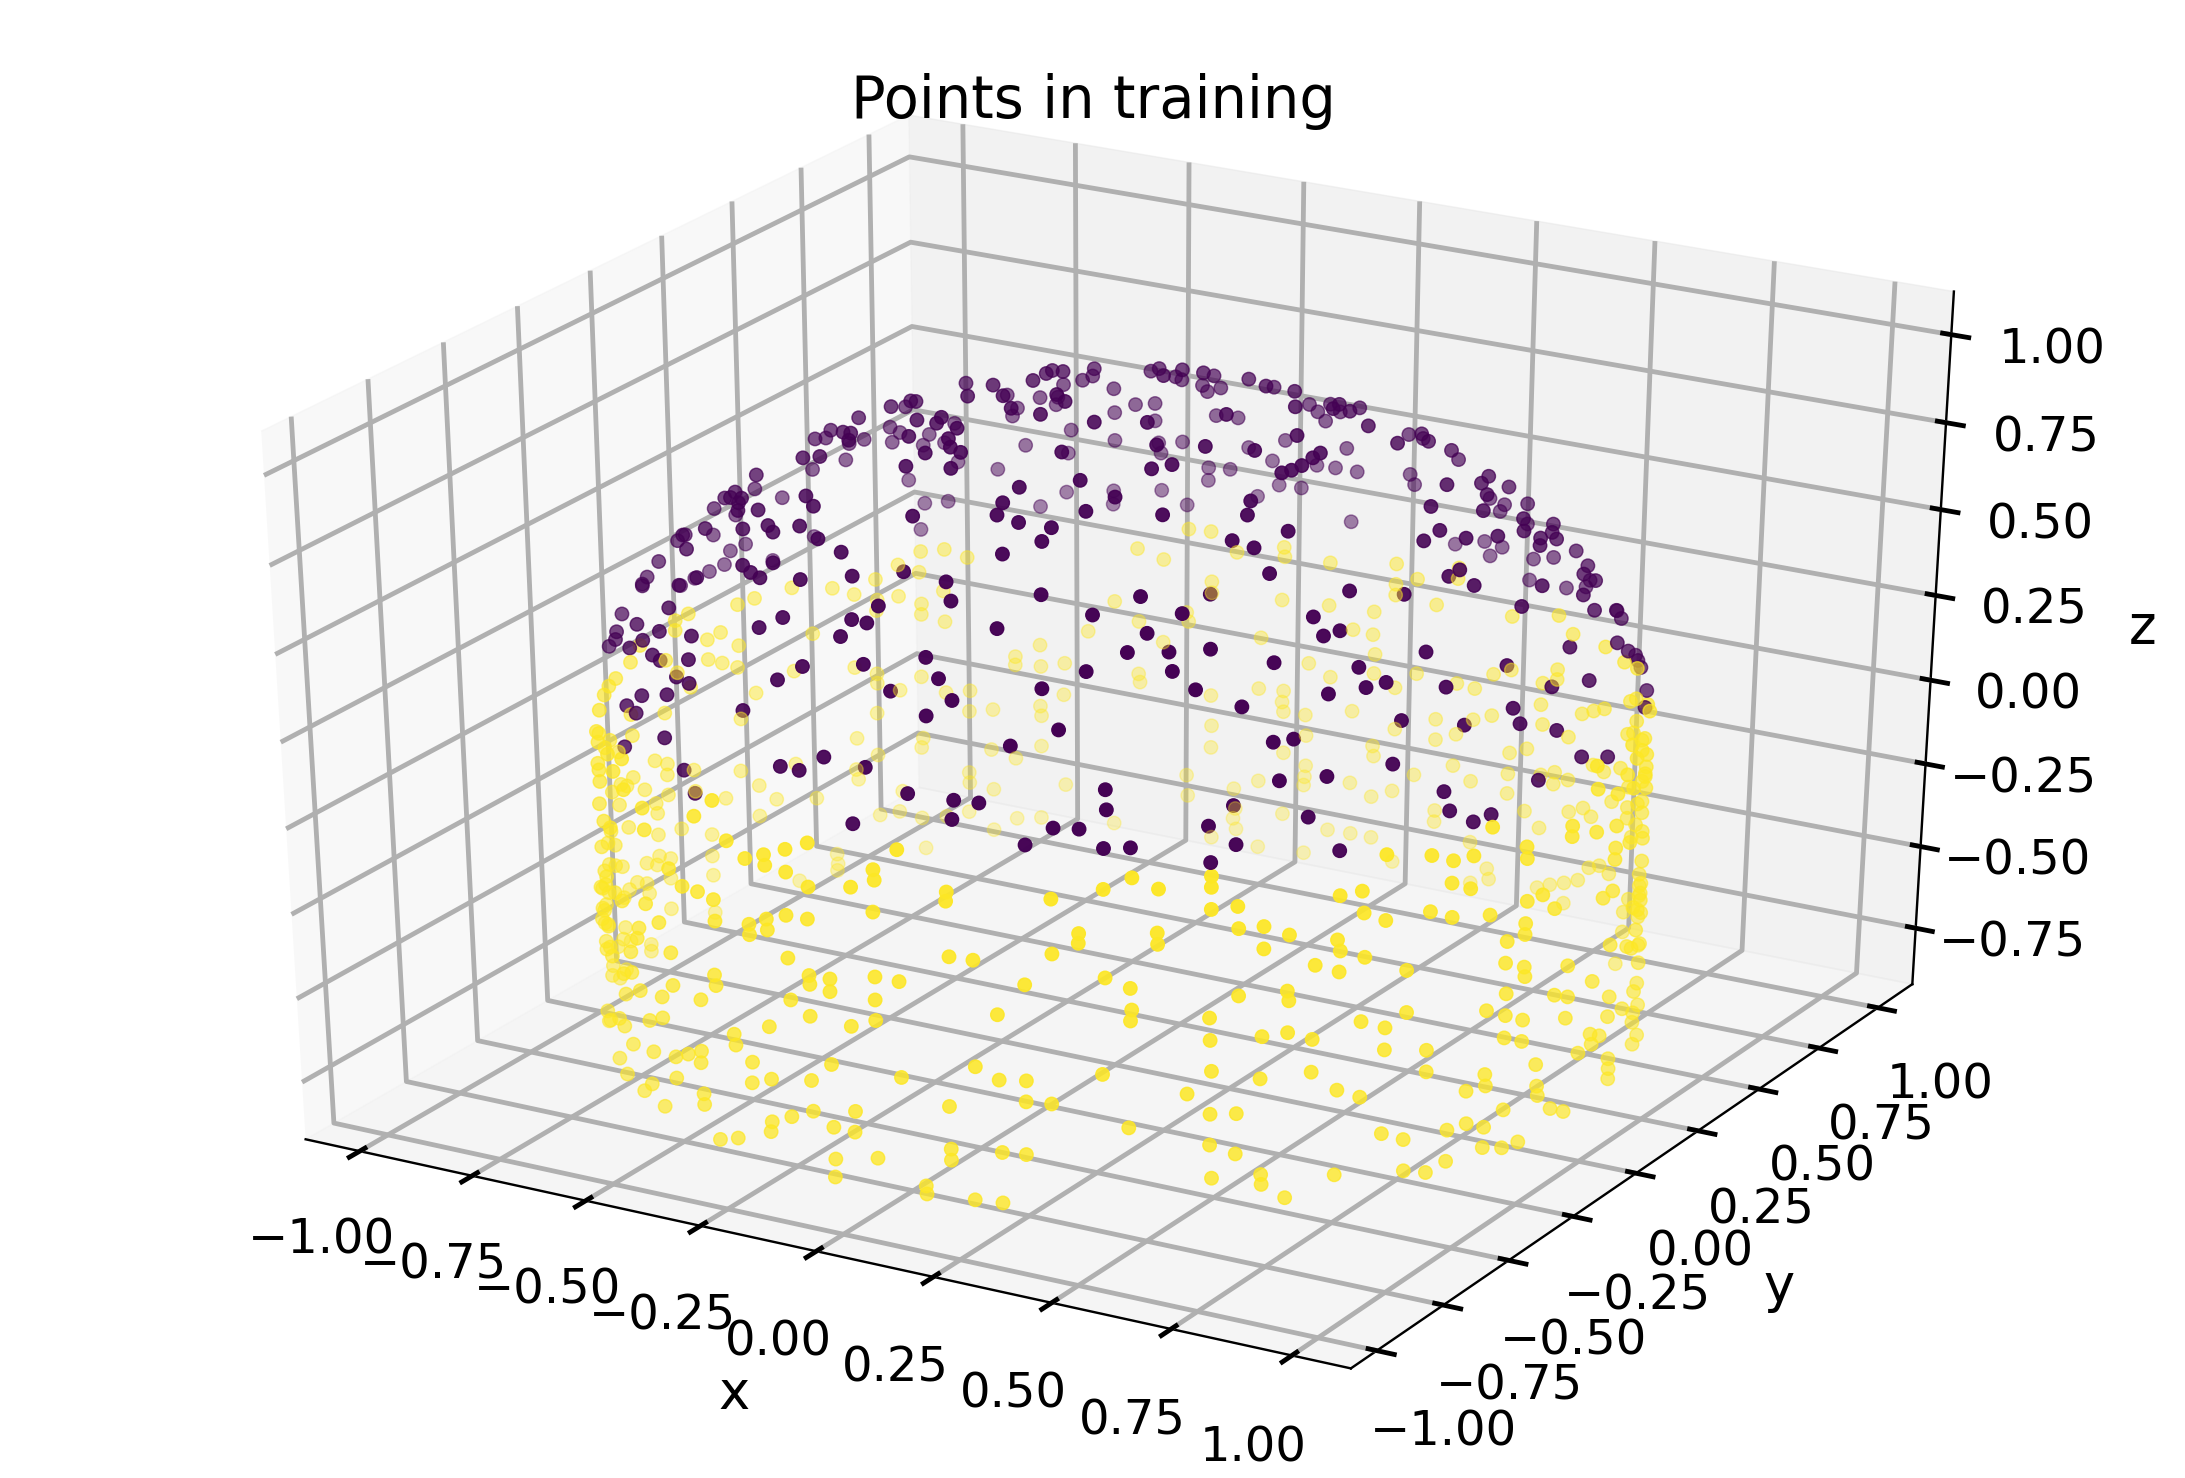

In [69]:
points = np.zeros((Y.shape[0], 3))
for i in range(Y.shape[0]):
  p = np.cross(Y[i,0:3], Y[i,3:6]) + Y[i,6]*Y[i,0:3] #calculate the points from the line elements
  points[i,:] = p
print(points.shape)
labels = points[:,2]*0
labels[np.where(points[:,2] < 0.2)] = 1

plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(points[:, 0], points[:,1], points[:, 2], c = labels)
ax.set_title('Points in training')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

filename = shape_name_string + ' points in training.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)

In [70]:
#use this to create an interactive 3D plot, use mouse buttons to translate, rotate and zoom
fig = go.Figure(data=[go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:, 2],
                                   mode='markers',
                                   marker=dict(size=5, color = labels, colorscale='Bluered',opacity=1.0)
                                   )])
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=4
    ),
)
fig.show( )

In [71]:
max_nr_of_iters = 25000

init='PCA'
#init='random'

likelihood_variance = 1e-6
likelihood_variance_fix = True 

optimizer = 'scg'
optimizer = 'lbfgs'
#optimizer = 'tnc'

num_restarts = 3

input_dim = 7 #Y.shape[1]
num_inducing= 25

In [72]:
mapping = mappings.MLP(input_dim=Y.shape[1], output_dim=input_dim, hidden_dim=5)

# back_kernel = GPy.kern.RBF(Y.shape[1]) #this is more smooth mapping
# mapping = GPy.mappings.Kernel(input_dim = Y.shape[1], Z=Y, output_dim=input_dim, kernel=back_kernel)

In [73]:
k_GPLVM = GPy.kern.RBF(input_dim, ARD = True)

m_GPLVM = GPy.models.BCGPLVM(Y, input_dim, kernel=k_GPLVM, mapping = mapping)

if likelihood_variance_fix:
  m_GPLVM.likelihood.variance = likelihood_variance
  m_GPLVM.likelihood.variance.fix()

m_GPLVM.optimize_restarts(messages=1, num_restarts=num_restarts, max_iters=max_nr_of_iters, optimizer = optimizer) 
print(m_GPLVM) 

Optimization restart 1/3, f = -35661.58046732308


Optimization restart 2/3, f = -36391.40916503254


Optimization restart 3/3, f = -36389.21811055859

Name : GPLVM
Objective : -36391.40916503254
Number of Parameters : 91
Number of Optimization Parameters : 90
Updates : True
Parameters:
  GPLVM.                   |              value  |  constraints  |  priors
  rbf.variance             |  8.995844106157998  |      +ve      |        
  rbf.lengthscale          |               (7,)  |      +ve      |        
  Gaussian_noise.variance  |              1e-06  |   +ve fixed   |        
  mlpmap.W1                |             (7, 5)  |               |        
  mlpmap.b1                |               (5,)  |               |        
  mlpmap.W2                |             (5, 7)  |               |        
  mlpmap.b2                |               (7,)  |               |        


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

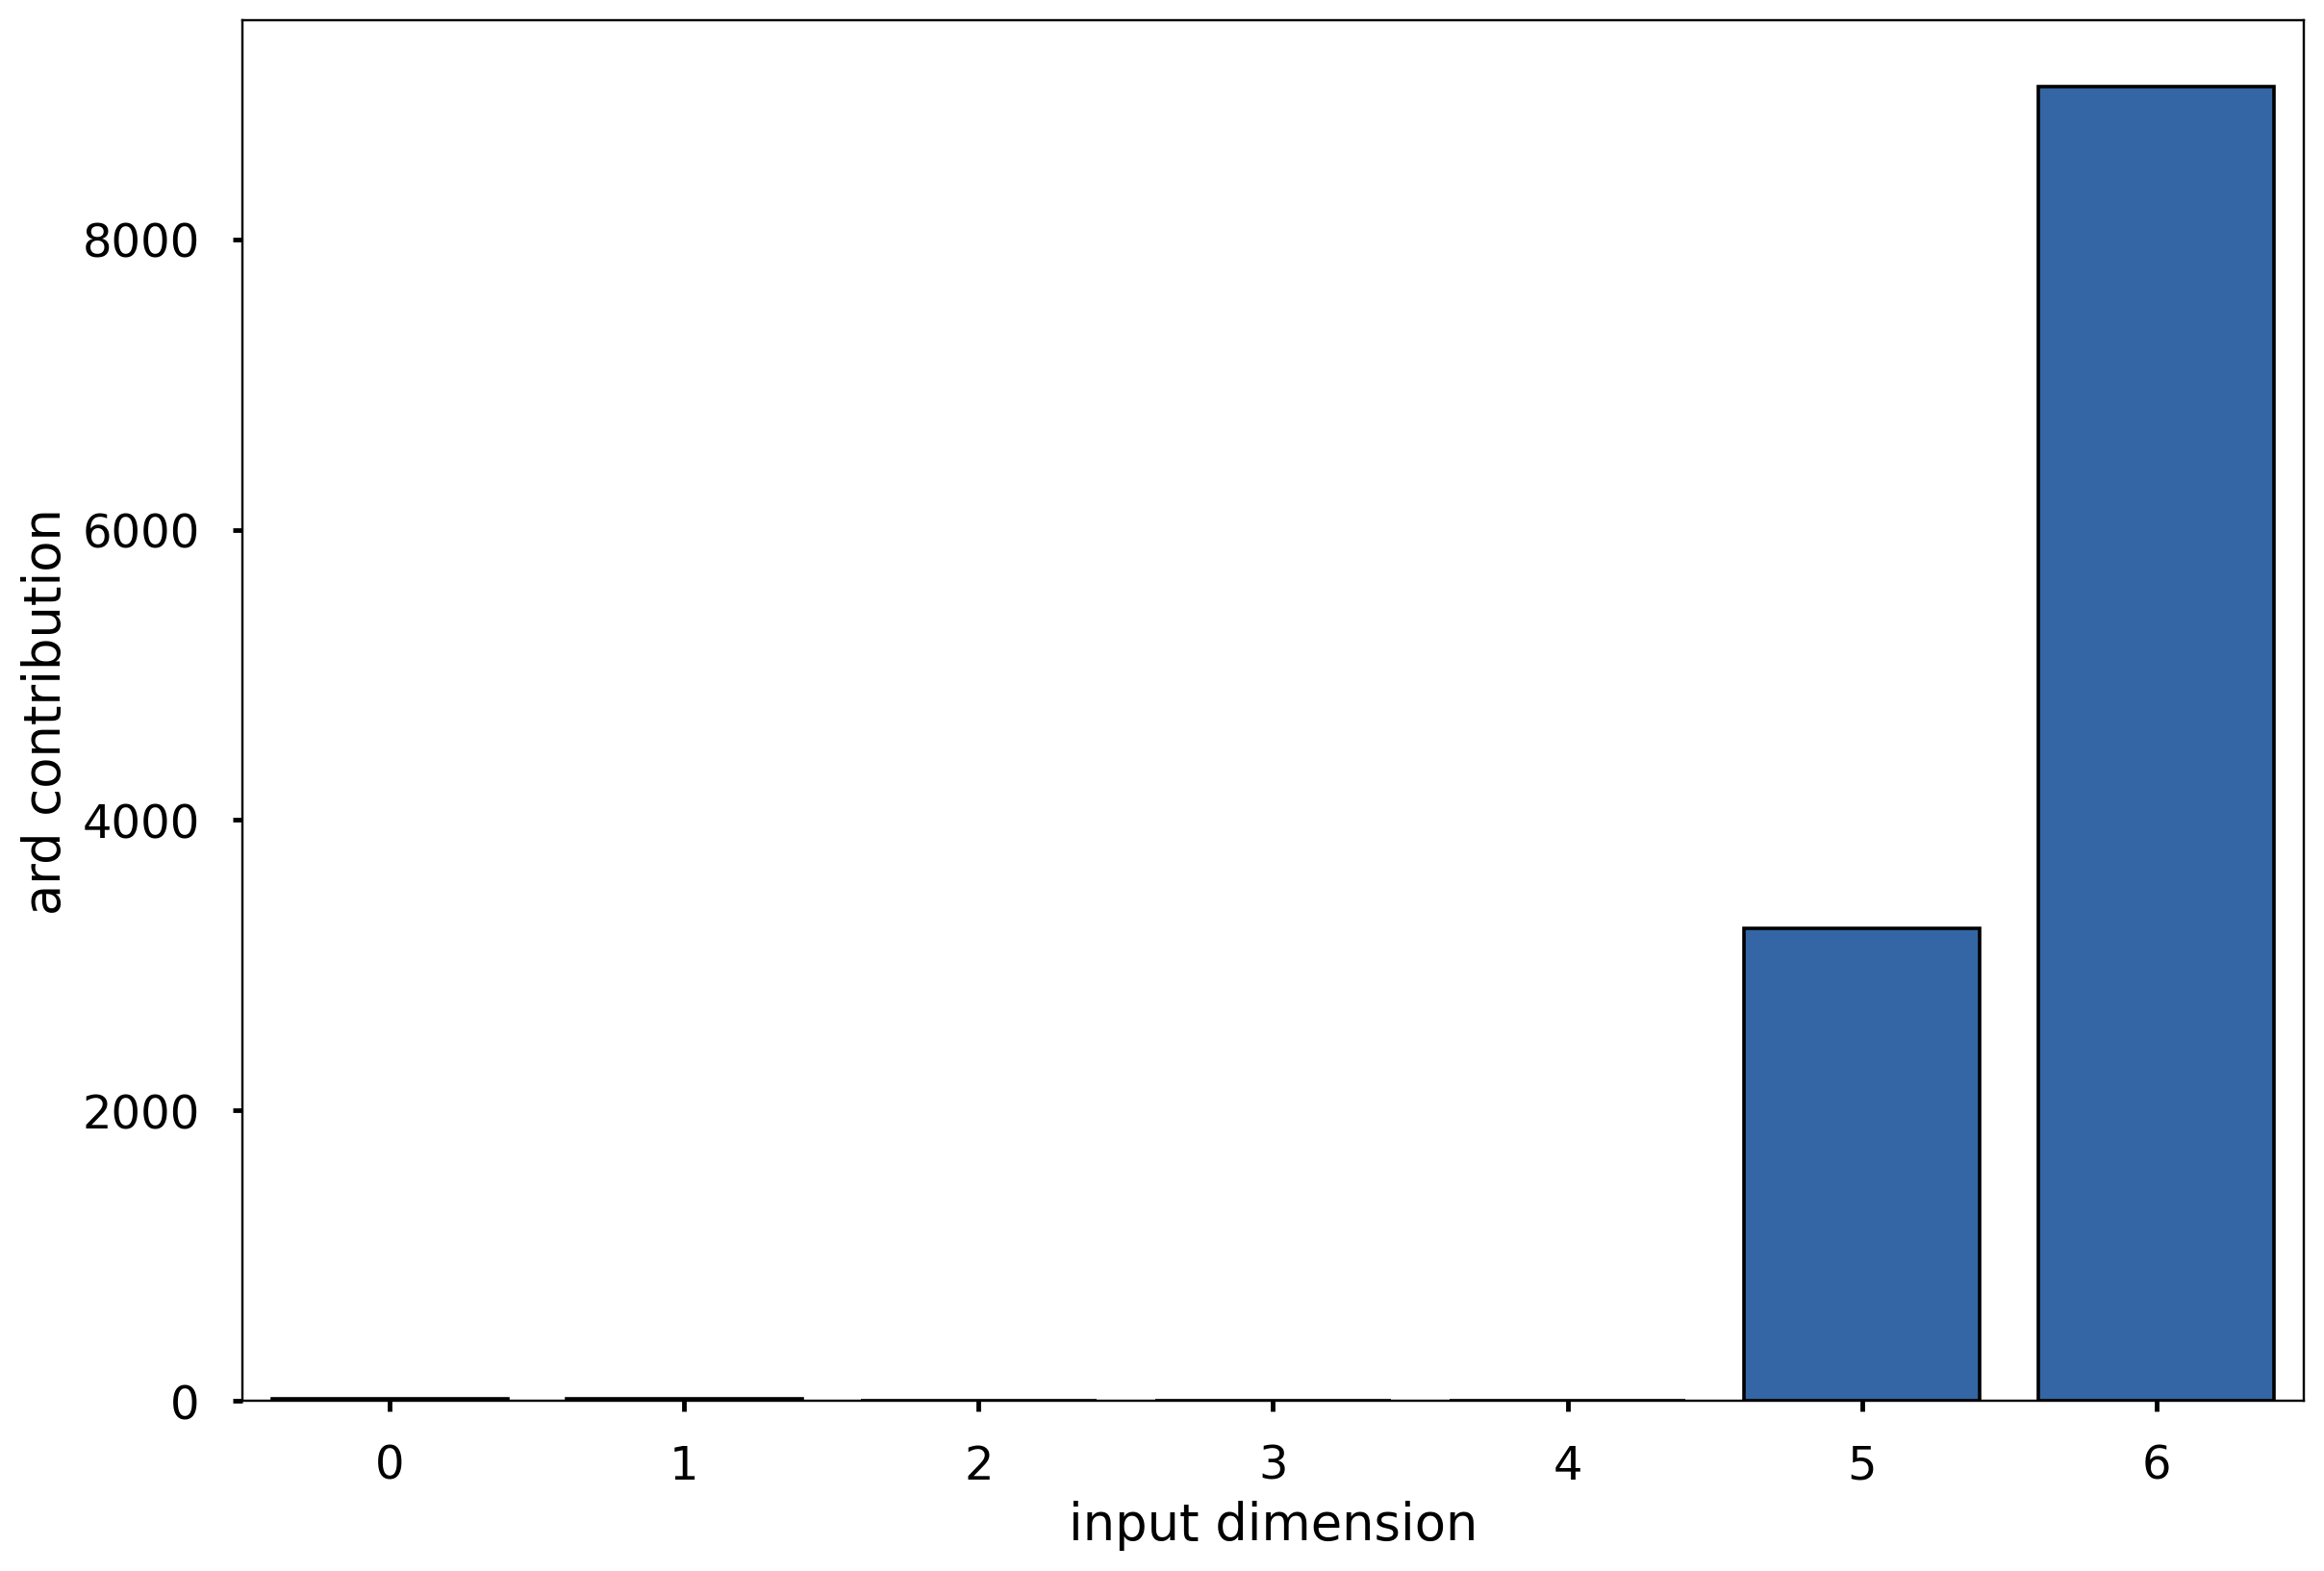

In [74]:
fig, ax = plt.subplots()
m_GPLVM.kern.plot_ARD(ax=ax)

filename = shape_name_string + ' ARD.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [75]:
m_GPLVM.kern.lengthscale #which is the inverse of ARD contribution

index,GPLVM.rbf.lengthscale,constraints,priors
[0],0.69942184,+ve,
[1],0.80975679,+ve,
[2],1.62988681,+ve,
[3],1.67732428,+ve,
[4],2.28128982,+ve,
[5],0.05255707,+ve,
[6],0.03152070,+ve,


In [76]:
lengthscales = m_GPLVM.kern.lengthscale.argsort()
input_dimension_1 =lengthscales[0]
input_dimension_2 =lengthscales[1]
input_dimension_3 =lengthscales[2]

print(input_dimension_1)
print(input_dimension_2)
print(input_dimension_3)

6
5
0


In [77]:
latent = m_GPLVM.X

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

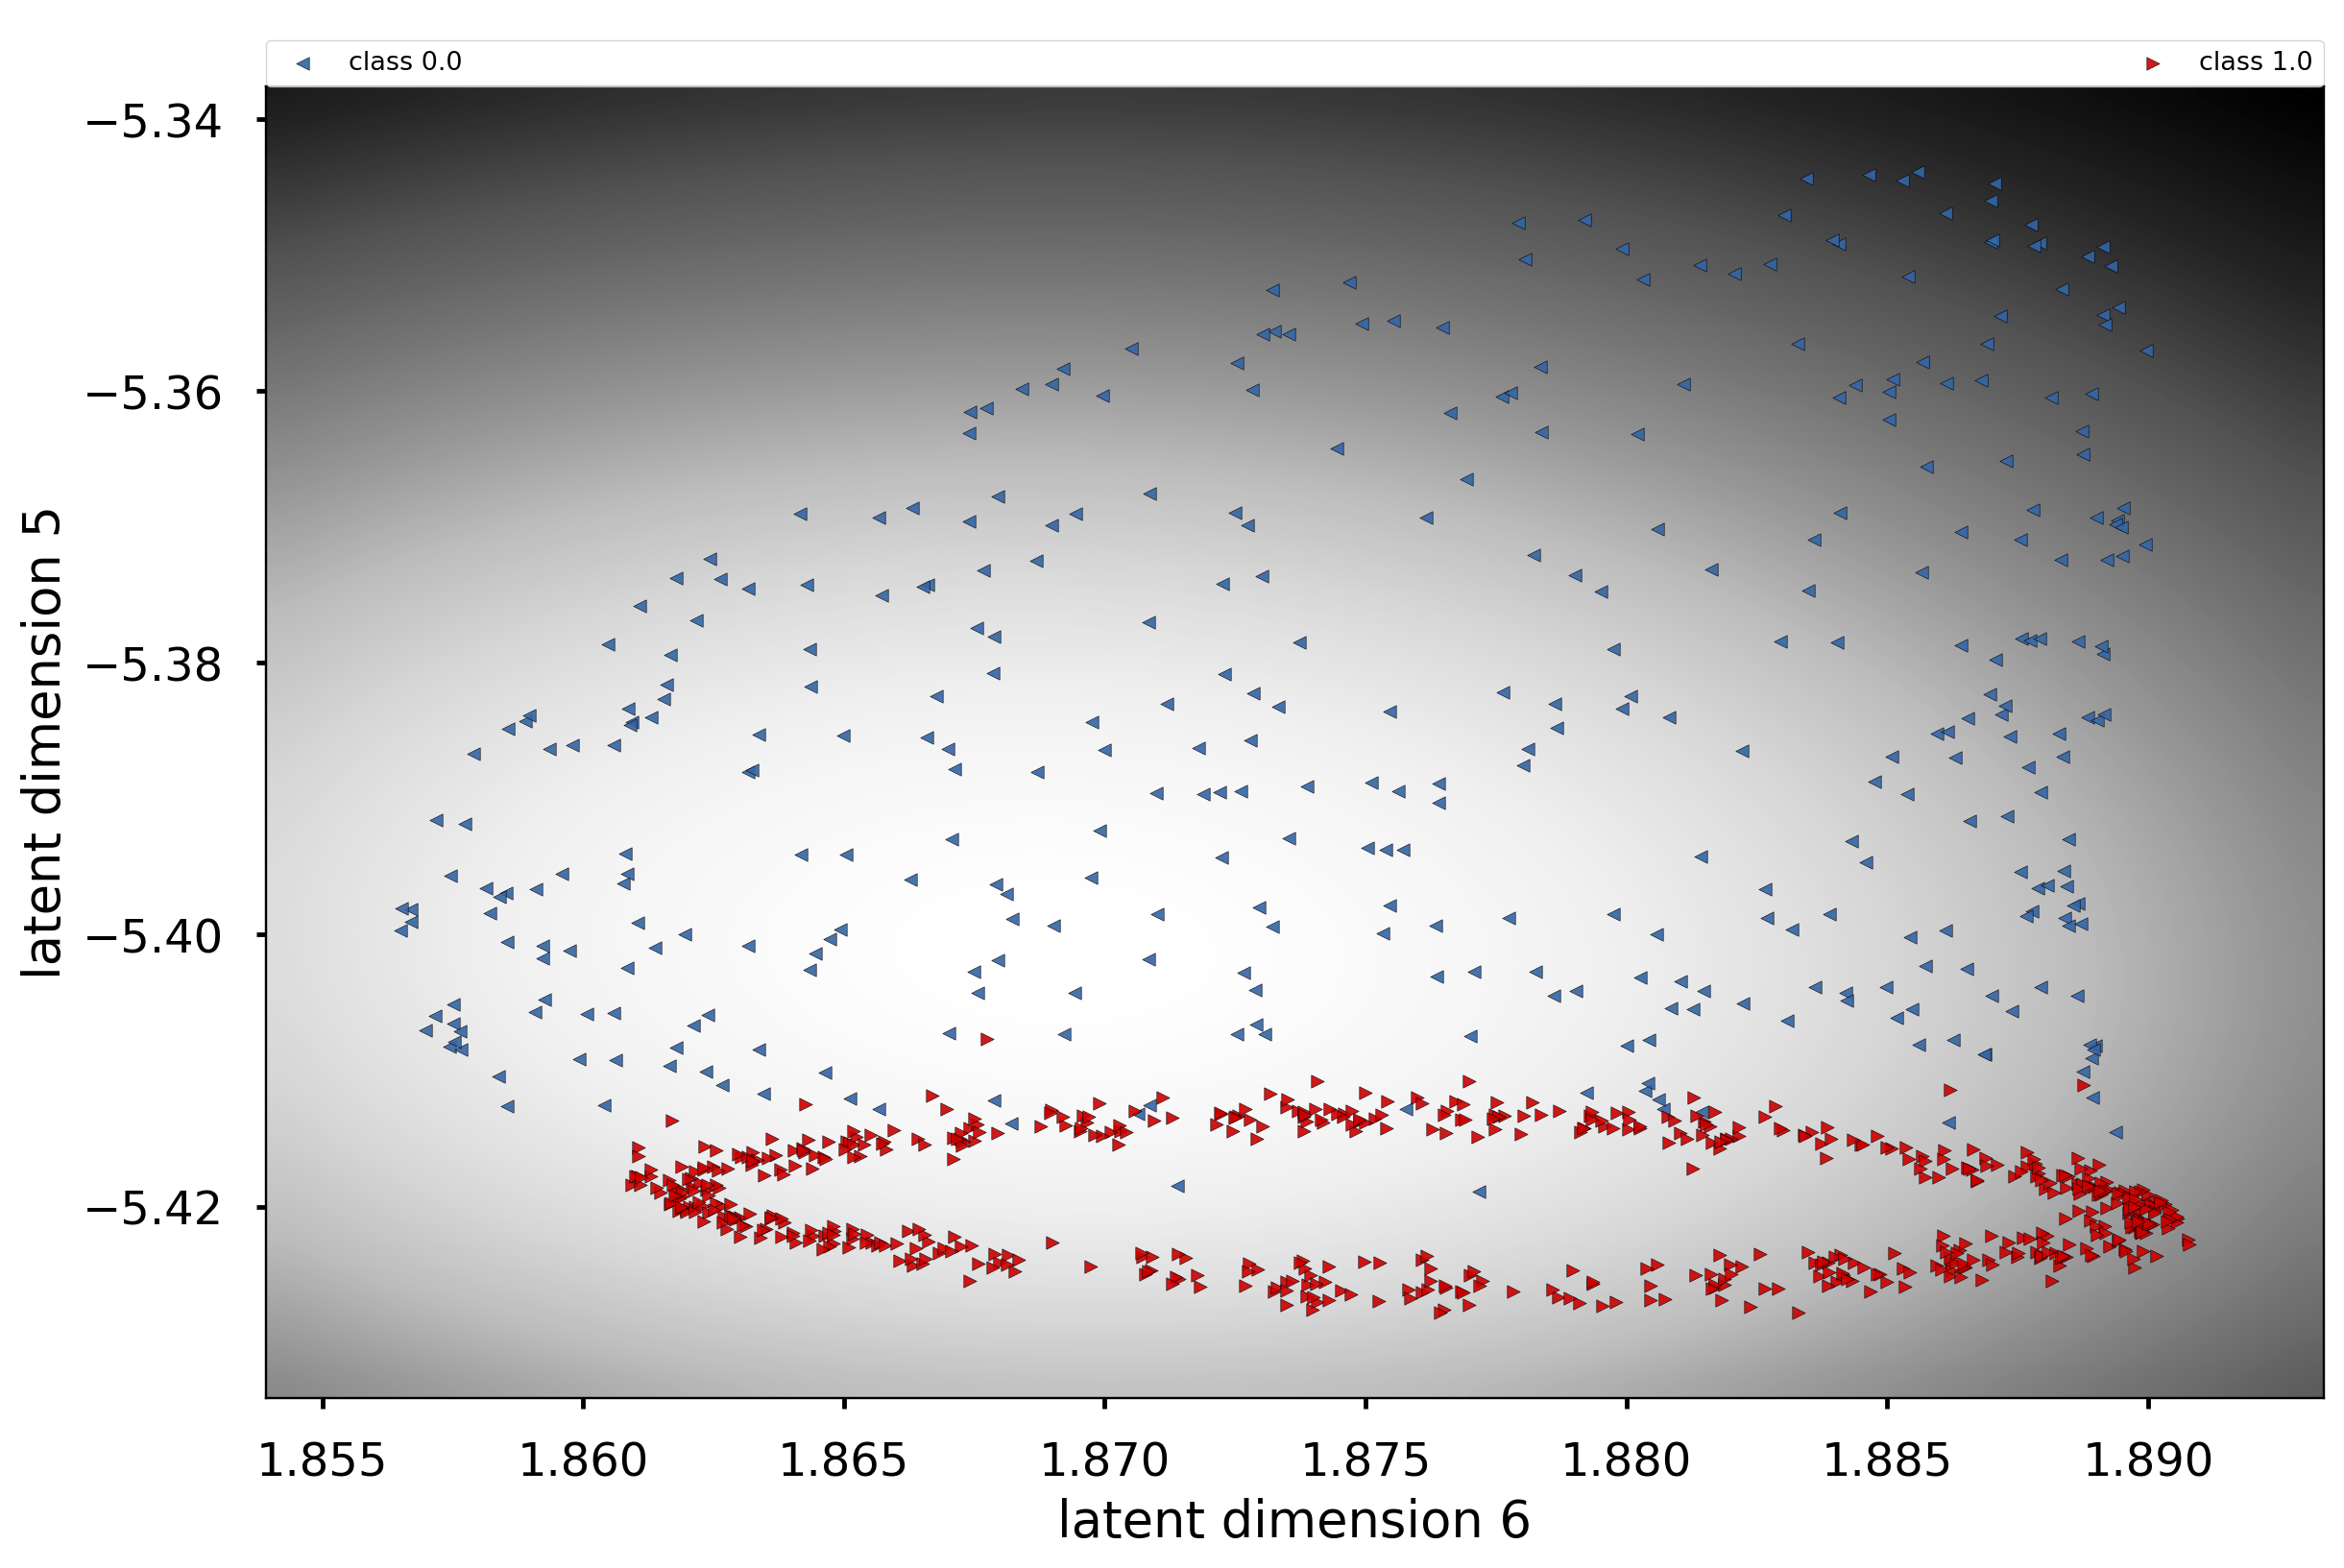

In [78]:
fig, ax = plt.subplots()
#ax.set_title('2D latent space')
m_GPLVM.plot_latent(labels = labels, ax=ax, updates=False, legend =True)
filename = shape_name_string + ' 2D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [79]:
#use this to create an interactive 3D plot, use mouse buttons to translate, rotate and zoom
fig = go.Figure(data=[go.Scatter3d(x=latent[:,input_dimension_1], y=latent[:,input_dimension_2], z=latent[:, input_dimension_3],
                                   mode='markers',
                                   marker=dict(size=5, color = labels, colorscale='Bluered',opacity=0.8)
                                   )])
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=4
    ),
)
fig.show( )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

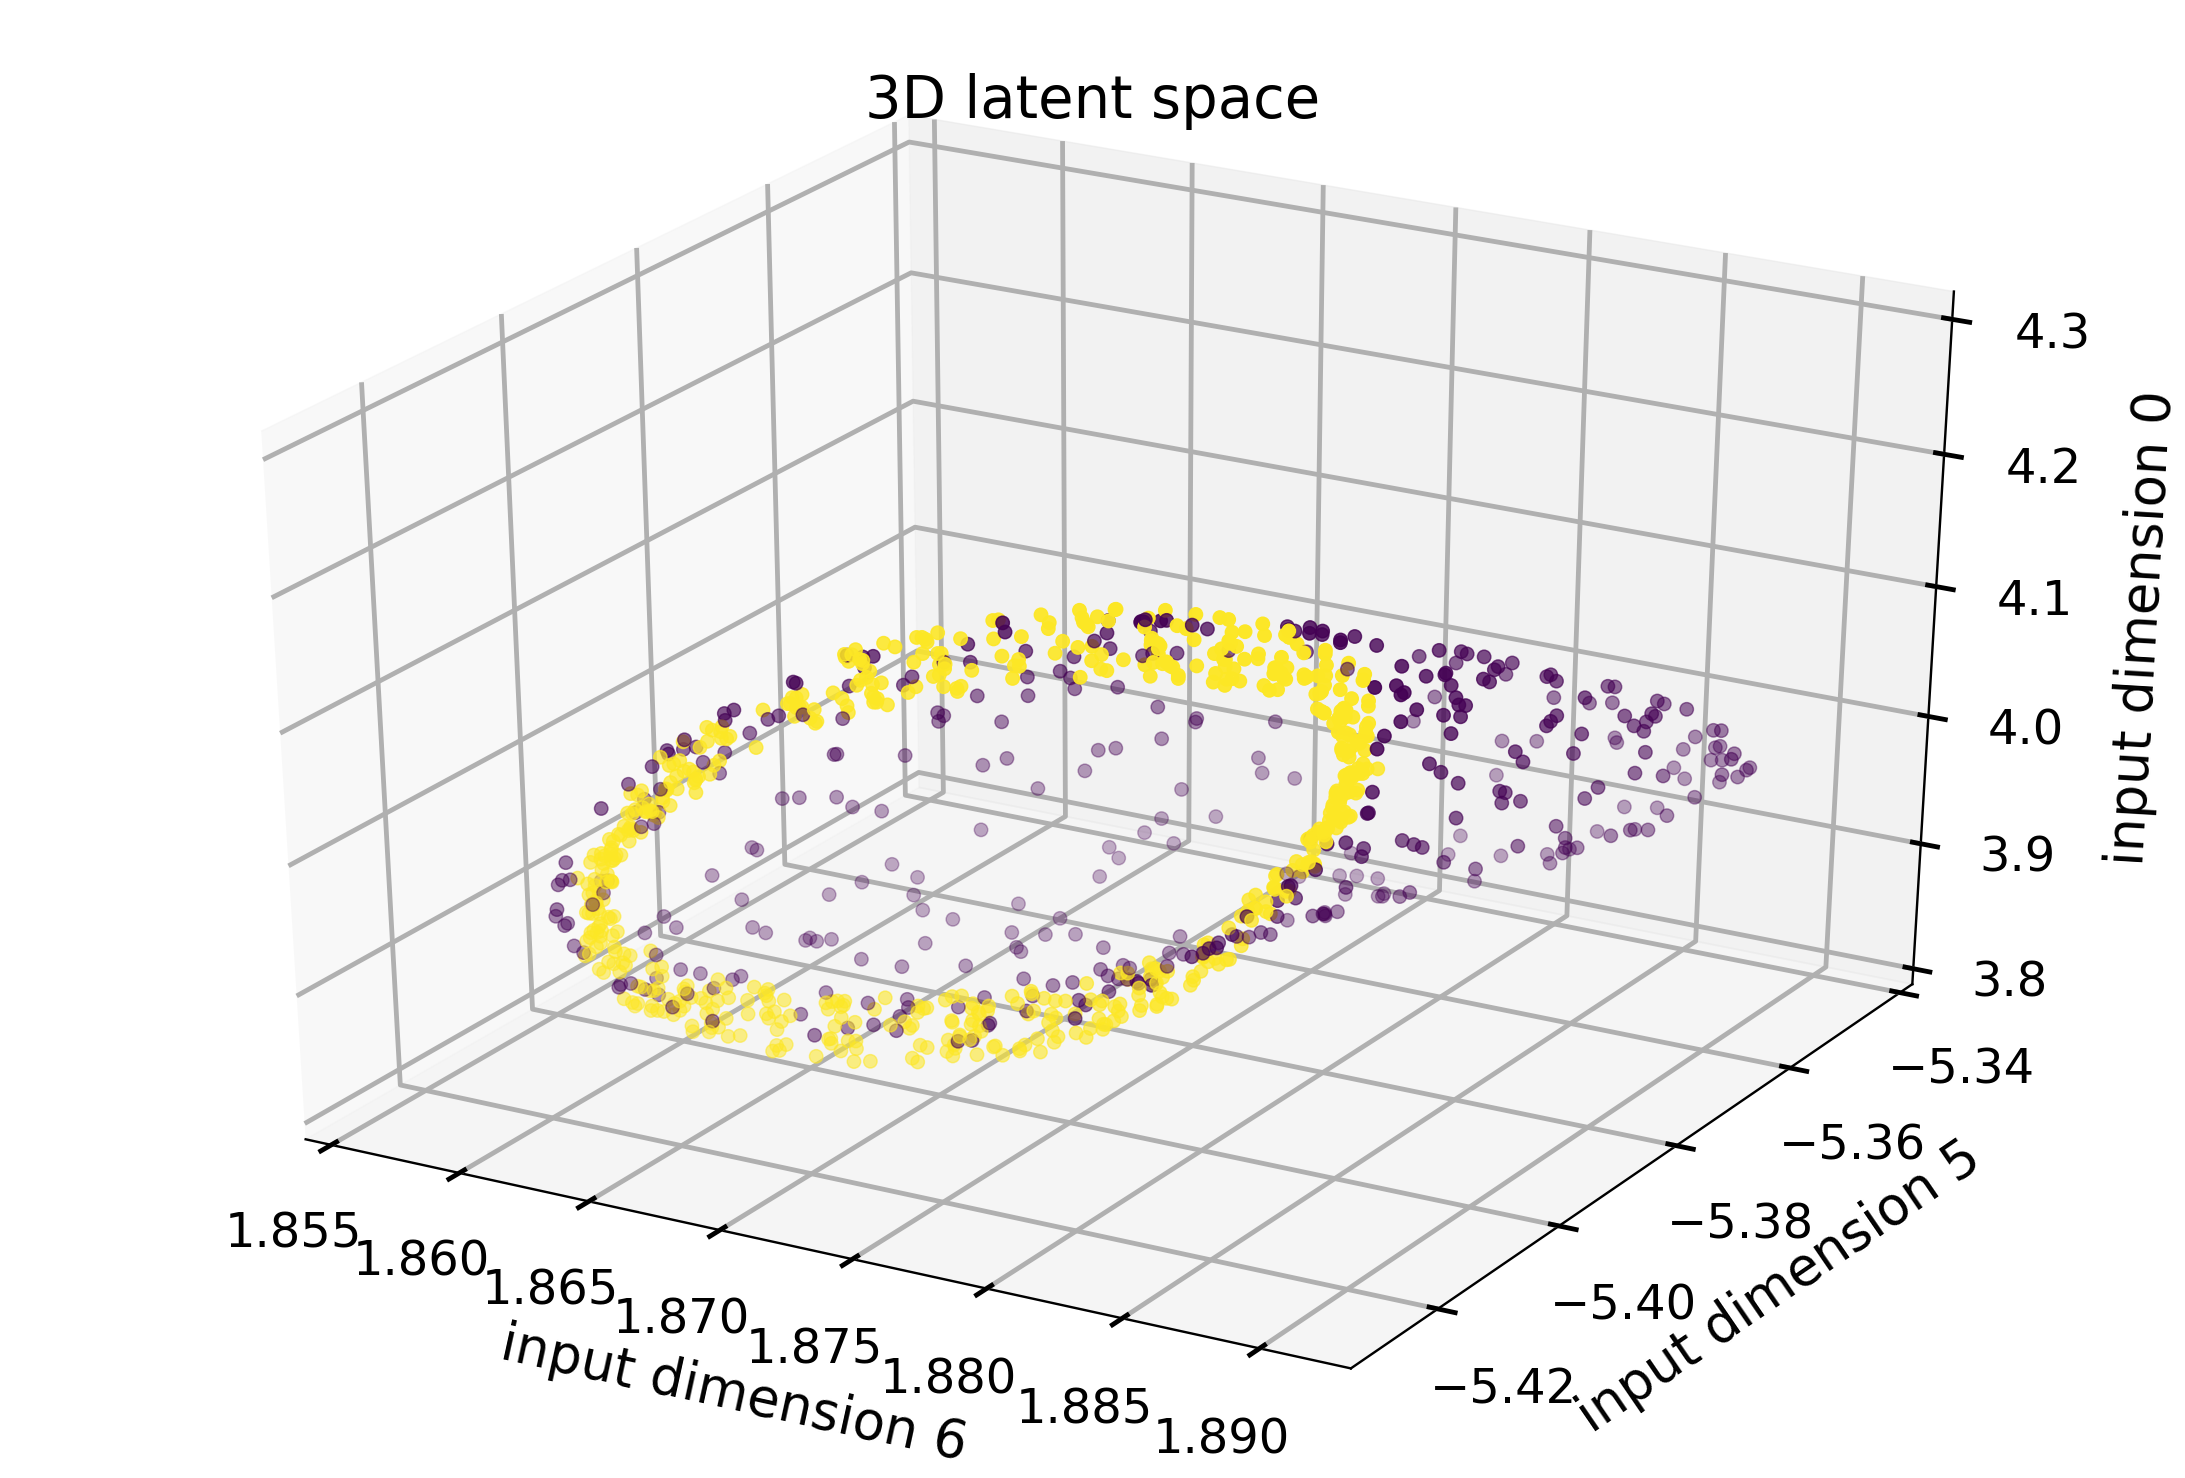

In [80]:
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(latent[:, input_dimension_1], latent[:,input_dimension_2], latent[:, input_dimension_3], c = labels)
ax.set_title('3D latent space')

# Set axes label
ax.set_xlabel('input dimension ' + str(input_dimension_1), labelpad=20)
ax.set_ylabel('input dimension ' + str(input_dimension_2), labelpad=20)
ax.set_zlabel('input dimension ' + str(input_dimension_3), labelpad=20)

filename = shape_name_string + ' 3D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)



#Save/load the model

In [81]:
# 1: Saving a model:
filename = shape_name_string + ' BCGPLVM.npy'
np.save(filename, m_GPLVM.param_array)
files.download('/content/' + filename)
print(m_GPLVM)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Name : GPLVM
Objective : -36391.40916503254
Number of Parameters : 91
Number of Optimization Parameters : 90
Updates : True
Parameters:
  GPLVM.                   |              value  |  constraints  |  priors
  rbf.variance             |  8.995844106157998  |      +ve      |        
  rbf.lengthscale          |               (7,)  |      +ve      |        
  Gaussian_noise.variance  |              1e-06  |   +ve fixed   |        
  mlpmap.W1                |             (7, 5)  |               |        
  mlpmap.b1                |               (5,)  |               |        
  mlpmap.W2                |             (5, 7)  |               |        
  mlpmap.b2                |               (7,)  |               |        


In [82]:
# 2: loading a model
# Model creation, without initialization:
m_load = GPy.models.BCGPLVM(Y, input_dim, kernel=k_GPLVM, mapping = mapping, initialize=False)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load(filename) # Load the parameters
m_load.update_model(True) # Call the algebra only once
print(m_load)


Name : GPLVM
Objective : -36391.40916503254
Number of Parameters : 91
Number of Optimization Parameters : 91
Updates : True
Parameters:
  GPLVM.                   |              value  |  constraints  |  priors
  rbf.variance             |  8.995844106157998  |      +ve      |        
  rbf.lengthscale          |               (7,)  |      +ve      |        
  Gaussian_noise.variance  |              1e-06  |      +ve      |        
  mlpmap.W1                |             (7, 5)  |               |        
  mlpmap.b1                |               (5,)  |               |        
  mlpmap.W2                |             (5, 7)  |               |        
  mlpmap.b2                |               (7,)  |               |        
